# PROYECTO FINAL MASTER DE DATA ANALITYCS - PEDRO PEREIRA VAZ

- El objeto de este proyecto, es analizar las tendencias sobre el paro en España desde 2021 hasta 2024, para lo cual se a recopilado de datos.gob.es 4 datasets de paro por municipios, sectores, generos y edad, y un quinto dataset con la poblacion por año y genero de 2021 hasta 2024, y se procede a procesarlo, limpiarlo, transformarlo y preparar todo el conjunto para dejarlo listo para su uso en un dashboard.

# 0. Requisitos previos

## 0.1 Importación de liberias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

## 0.2 Configuración estilos

In [2]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12,6)

# 1. ETL

## 1.0 Importar y preprocesar dataset complementario de Poblacion España por Municipio Edad y Genero

In [3]:
df_poblacion = pd.read_csv("data/poblacion_spain.csv", encoding="utf-8", sep=";", dtype={'Total': str})

- Eliminamos columnas prescindibles
- Eliminamos datos nulos
- Remplazamos los puntos de los valores numericos Total y convertimos a entero
- Extraemos el municipio y el codigo de municipio de Municipios y eliminamos Municipios
- Corregimos tipo de datos

In [4]:
df_poblacion.drop(columns=['Total Nacional', 'Provincias'], inplace=True)
df_poblacion.dropna(inplace=True)
df_poblacion[['codigo_municipio', 'nombre_municipio']] = df_poblacion['Municipios'].str.split(' ', n=1, expand=True)
df_poblacion['Total'] = df_poblacion['Total'].str.replace('.', '', regex=False).astype(int)
df_poblacion.drop(columns=['Municipios'], inplace=True)
df_poblacion['codigo_municipio'] = df_poblacion['codigo_municipio'].astype(int)

- Eliminamos los datos agregados "todas las edades" en edad y "Total" en sexo, dado que la suma de poblacion por edad y genero.

In [5]:
df_poblacion = df_poblacion[df_poblacion["Sexo"]!="Total"]
df_poblacion = df_poblacion[df_poblacion["Edad"]!="Todas las edades"]

- Convertir la columna 'Edad' a número (quitando ' años' y controlando "100 y más años")
- Filtrar solo entre 18 y 65 años

In [6]:
df_poblacion['Edad_num'] = df_poblacion['Edad'].str.extract(r'(\d+)').astype(int)
df_poblacion.drop(columns=['Edad'], inplace=True)
df_poblacion = df_poblacion[(df_poblacion['Edad_num'] >= 18) & (df_poblacion['Edad_num'] <= 65)].copy()

- Creamos rangos de edad que coinciden con el dataset del paro

In [7]:
def categorizar_edad(edad):
    if 18 <= edad <= 24:
        return '<25'
    elif 25 <= edad <= 45:
        return '25_45'
    elif 46 <= edad <= 65:
        return '>=45'
    return None

df_poblacion['RangoEdad'] = df_poblacion['Edad_num'].apply(categorizar_edad)


- Agrupamos por municipio, periodo, sexo y rango de edad y ordenamos resultados

In [8]:
df_poblacion = (
    df_poblacion
    .groupby(['codigo_municipio', 'nombre_municipio','Periodo', 'Sexo', 'RangoEdad'], as_index=False)['Total']
    .sum()
)
df_poblacion = df_poblacion.sort_values(['codigo_municipio','Periodo', 'Sexo', 'RangoEdad'])

- Renombramos Periodo por Year para posterior fusion con dataframe de paro

In [9]:
df_poblacion.rename(columns={"Periodo":"year"},inplace=True)

- Creamos las columnas para pivotar el dataframe al formato que tiene en paro

In [10]:
df_poblacion['columna'] = (
    'poblacion_' 
    + df_poblacion['Sexo'].str.lower() 
    + '_edad_' 
    + df_poblacion['RangoEdad']
)

- Pivotamos el dataframe para coincidir con el de Paro

In [11]:
df_poblacion = df_poblacion.pivot_table(
    index=['codigo_municipio','year'],
    columns='columna',
    values='Total',
    aggfunc='sum'
).reset_index()

In [12]:
df_poblacion.isna().sum()

columna
codigo_municipio                0
year                            0
poblacion_hombres_edad_25_45    0
poblacion_hombres_edad_<25      0
poblacion_hombres_edad_>=45     0
poblacion_mujeres_edad_25_45    0
poblacion_mujeres_edad_<25      0
poblacion_mujeres_edad_>=45     0
dtype: int64

In [13]:
df_poblacion.sample(5)

columna,codigo_municipio,year,poblacion_hombres_edad_25_45,poblacion_hombres_edad_<25,poblacion_hombres_edad_>=45,poblacion_mujeres_edad_25_45,poblacion_mujeres_edad_<25,poblacion_mujeres_edad_>=45
26641,44131,2022,10,2,6,4,0,4
7227,11040,2024,60,12,78,57,19,70
24359,41018,2024,1872,530,1891,1795,526,1877
25595,43038,2024,4521,1475,5525,4774,1361,5815
25927,43122,2024,19,6,29,22,3,22


In [14]:
df_poblacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32525 entries, 0 to 32524
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   codigo_municipio              32525 non-null  int64
 1   year                          32525 non-null  int64
 2   poblacion_hombres_edad_25_45  32525 non-null  int64
 3   poblacion_hombres_edad_<25    32525 non-null  int64
 4   poblacion_hombres_edad_>=45   32525 non-null  int64
 5   poblacion_mujeres_edad_25_45  32525 non-null  int64
 6   poblacion_mujeres_edad_<25    32525 non-null  int64
 7   poblacion_mujeres_edad_>=45   32525 non-null  int64
dtypes: int64(8)
memory usage: 2.0 MB


## 1.1 Importación de datasets con los datos del paro de datos.gob.es de los años 2021-2024 y Dataset Poblacion España por Municipio Edad Genero

In [15]:
df_2021 = pd.read_csv("data/Paro_por_municipios_2021_csv.csv", encoding="latin1", skiprows=1, sep=";")
df_2022 = pd.read_csv("data/Paro_por_municipios_2022_csv.csv", encoding="latin1", skiprows=1, sep=";")
df_2023 = pd.read_csv("data/Paro_por_municipios_2023_csv.csv", encoding="latin1", skiprows=1, sep=";")
df_2024 = pd.read_csv("data/Paro_por_municipios_2024_csv.csv", encoding="latin1", skiprows=1, sep=";")

## 1.2 Unificamos dataframes de los años 2021 a 2024, ordenamos por Fecha, Comunidad Autonoma, Provincia y Municipio, y reiniciamos indices

In [16]:
df_completo = pd.concat([df_2021,df_2022,df_2023,df_2024], ignore_index=True).sort_values(by=["Código mes ", "Código de CA", "Codigo Provincia", "Codigo Municipio"]).reset_index(inplace=False,drop=True)

## 1.3 Obtenemos una muestra para comprobar el dataframe resultante

In [17]:
df_completo.sample(5)

,Código mes,mes,Código de CA,Comunidad Autónoma,Codigo Provincia,Provincia,Codigo Municipio,Municipio,total Paro Registrado,Paro hombre edad < 25,Paro hombre edad 25 -45,Paro hombre edad >=45,Paro mujer edad < 25,Paro mujer edad 25 -45,Paro mujer edad >=45,Paro Agricultura,Paro Industria,Paro Construcción,Paro Servicios,Paro Sin empleo Anterior
178649,202210,Octubre de 2022,16,País Vasco,20,Gipuzkoa,20078,Zaldibia,57,<5,7,16,6,12,14,<5,12,5,34,<5
229199,202305,Mayo de 2023,2,Aragón,50,Zaragoza,50233,Samper del Salz,0,0,0,0,0,0,0,0,0,0,0,0
165370,202209,Septiembre de 2022,7,Castilla y León,34,Palencia,34015,Arconada,0,0,0,0,0,0,0,0,0,0,0,0
10303,202102,Febrero de 2021,7,Castilla y León,9,Burgos,9085,Castrillo de la Vega,60,8,8,12,4,16,12,21,9,2,26,2
70053,202109,Septiembre de 2021,8,Castilla - La Mancha,45,Toledo,45169,Torralba de Oropesa,20,0,3,4,0,6,7,3,1,1,15,0


Observación: Los datos numericos de paro incluyen valores no numericos como menor que o mayor que NUMERO.

## 1.4 Inspección inicial

### Comprobamos las dimensiones

In [18]:
df_completo.shape

(390432, 20)

Tenemos un dataframe resultante de casi 400 mil filas y 20 columnas

### Comprobamos los nombres de las columnas

In [19]:
df_completo.columns

Index(['Código mes ', 'mes', 'Código de CA', 'Comunidad Autónoma',
       'Codigo Provincia', 'Provincia', 'Codigo Municipio', ' Municipio',
       'total Paro Registrado', 'Paro hombre edad < 25',
       'Paro hombre edad 25 -45 ', 'Paro hombre edad >=45',
       'Paro mujer edad < 25', 'Paro mujer edad 25 -45 ',
       'Paro mujer edad >=45', 'Paro Agricultura', 'Paro Industria',
       'Paro Construcción', 'Paro Servicios', 'Paro Sin empleo Anterior'],
      dtype='object')

- Código mes: año y mes con formato aaaamm
- Mes: Nombre del mes
- Código de CA: Codigo de cada comunidad autónoma
- Comunidad Autónoma: Nombre de cada comunidad autónoma
- Código Provincia: Codigo de cada provincia
- Provincia: Nombre de cada provincia
- Código Municipio: Codigo de cada municipio
- Municipio: Nombre de cada municipio
- total Paro Registrado: Computo total paro del municipio
- Paro hombre edad < 25, Paro hombre edad 25 -45, Paro hombre edad >=45, Paro mujer edad < 25, Paro mujer edad 25 -45, Paro mujer edad >=45 : Paro para cada genero y rango de edad del municipio
- Paro Agricultura, Paro Industria, Paro Construcción, Paro Servicios, Paro Sin empleo Anterior: Paro para cada sector del municipio

### Comprobamos los tipos de datos y nulos

In [20]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390432 entries, 0 to 390431
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Código mes                390432 non-null  int64 
 1   mes                       390432 non-null  object
 2   Código de CA              390432 non-null  int64 
 3   Comunidad Autónoma        390432 non-null  object
 4   Codigo Provincia          390432 non-null  int64 
 5   Provincia                 390432 non-null  object
 6   Codigo Municipio          390432 non-null  int64 
 7    Municipio                390432 non-null  object
 8   total Paro Registrado     390432 non-null  object
 9   Paro hombre edad < 25     390432 non-null  object
 10  Paro hombre edad 25 -45   390432 non-null  object
 11  Paro hombre edad >=45     390432 non-null  object
 12  Paro mujer edad < 25      390432 non-null  object
 13  Paro mujer edad 25 -45    390432 non-null  object
 14  Paro

No se encuentran datos nulos y las columnas de Paro no estan establecidas como numericas debido a que incluyen datos como "<5" los cuales no son valores absolutos.

### Comprobamos estadísticas de columnas numéricas

In [21]:
df_completo.describe()

,Código mes,Código de CA,Codigo Provincia,Codigo Municipio
count,390432.000000,390432.000000,390432.000000,390432.000000
mean,202256.500000,7.737890,26.655397,26786.323211
std,111.856822,4.030824,14.891071,14889.305023
min,202101.000000,1.000000,1.000000,1001.000000
25%,202178.750000,7.000000,13.000000,13087.000000
50%,202256.500000,7.000000,26.000000,26016.500000
75%,202334.250000,10.000000,41.000000,41026.000000
max,202412.000000,19.000000,52.000000,52001.000000


Las columnas actuales categorizadas como numericas no proporcionan información util, dado que son columnas de fecha y ubicación

## 1.5 Renombrar columnas y estandarizar

Eliminamos espacios finales, formatemos a minusculas, reemplazamos espacios intermedios o guiones por guiones bajos

In [22]:
df_completo.rename(columns=lambda x: x.strip().lower().replace(' ', '_').replace('-', '_'), inplace=True)

In [23]:
df_completo.columns

Index(['código_mes', 'mes', 'código_de_ca', 'comunidad_autónoma',
       'codigo_provincia', 'provincia', 'codigo_municipio', 'municipio',
       'total_paro_registrado', 'paro_hombre_edad_<_25',
       'paro_hombre_edad_25__45', 'paro_hombre_edad_>=45',
       'paro_mujer_edad_<_25', 'paro_mujer_edad_25__45',
       'paro_mujer_edad_>=45', 'paro_agricultura', 'paro_industria',
       'paro_construcción', 'paro_servicios', 'paro_sin_empleo_anterior'],
      dtype='object')

## 1.6 Revisar y limpiar valores faltantes

El dataframe carece de valores faltantes aparentemente, pero tiene valores no absolutos que nos impidén asignar un tipo de dato numerico para las columnas del paro por el valor "<5", procedemos a cambiarlos por NaN y eliminar para transformar los datos a formato numerico.
- NOTA: Se intento antes de eliminarlos, realizar una imputación de valores realizando el calculo desde paro total y repartir el faltante entre los valores NaN, pero resulto no ser idoneo, procesar esos 400.000 registros a resultado en un procesamiento de mas de 20 minutos por lo que decido realizar este enfoque de eliminar los NaN y todos los municipios que tengan almenos un NaN en su historico de los 48 meses recolectados para trabajar con datos mas consistente y relevantes dado que esos municipios no representan un porcentaje significativo y el dataframe resultante mantiene unos 48700 filas.
- La premisa para intentar la imputación era, Para los valores faltantes, sabemos que <5 reprentante un valor entre 1-4, y que el paro total es igual a la suma de del paro desagregado por genero y edad y que tambien es igual a la suma de todo el paro por sector.
total_paro_registrado = todos los paro_genero_edad = paro_sector

- Por lo que procedemos a calcular la diferencia entre el total y los valores conocidos, y repartir el valor faltante entre los NaN.
- Finalmente descartada esta opción por tiempo largo de procesamiento.

Convertimos a NaN los valores no absolutos ("<5")

In [24]:
columnas_paro = df_completo.columns[8:]
df_completo[columnas_paro] = df_completo[columnas_paro].replace('<5', np.nan)
df_completo[columnas_paro] = df_completo[columnas_paro].astype(float)
filas_iniciales = len(df_completo)
municipios_iniciales = df_completo['codigo_municipio'].nunique()
paro_inicial = int(df_completo["total_paro_registrado"].sum())


Eliminamos todos los registros con NaN

In [25]:
df_completo = df_completo.dropna()

Eliminamos todos los municipios que no mantienen el historial completo de 48 meses despues de eliminar los NaN

In [26]:
conteo = df_completo.groupby("codigo_municipio").size()
municipios_validos = conteo[conteo == 48].index
df_completo = df_completo[df_completo["codigo_municipio"].isin(municipios_validos)].copy()

### Conservamos finalmente 48672 registros correspondientes a 1014 municipios con plena integridad historica de los datos y que representan el 83.6% de todo el paro registrado.

In [27]:
print(f"Filas iniciales: {filas_iniciales:,} | Filas finales: {len(df_completo):,} -> Diferencia: {len(df_completo) - filas_iniciales:+,} ({((len(df_completo) - filas_iniciales) / filas_iniciales) * 100:.2f}%)")
print(f"Municipios iniciales: {municipios_iniciales:,} | Municipios restantes: {df_completo['codigo_municipio'].nunique():,} -> Diferencia: {df_completo['codigo_municipio'].nunique() - municipios_iniciales:+,} ({((df_completo['codigo_municipio'].nunique() - municipios_iniciales) / municipios_iniciales) * 100:.2f}%)")
print(f"Total paro dataset inicial: {paro_inicial:,} | Total paro dataset: {int(df_completo['total_paro_registrado'].sum()):,} -> Diferencia: {int(df_completo['total_paro_registrado'].sum() - paro_inicial):+,} ({((df_completo['total_paro_registrado'].sum() - paro_inicial) / paro_inicial) * 100:.2f}%)")


Filas iniciales: 390,432 | Filas finales: 48,672 -> Diferencia: -341,760 (-87.53%)
Municipios iniciales: 8,134 | Municipios restantes: 1,014 -> Diferencia: -7,120 (-87.53%)
Total paro dataset inicial: 142,950,950 | Total paro dataset: 119,505,097 -> Diferencia: -23,445,853 (-16.40%)


## 1.7 Agregamos columna los datos de fecha en formato Datetime y extraemos year para fusion con dataset de Poblacion y corregimos de float a int las columnas de paro

In [28]:
df_completo['fecha'] = pd.to_datetime(df_completo['código_mes'].astype(str), format='%Y%m')

In [29]:
df_completo['year'] = df_completo['código_mes'].astype(str).str[:4].astype(int)

In [30]:
cols_paro = [c for c in df_completo.columns if c.startswith("paro_")]
df_completo[cols_paro] = df_completo[cols_paro].astype(int)
df_completo["total_paro_registrado"] = df_completo["total_paro_registrado"].astype(int)

## 1.8 Fusionamos dataframe del Paro y Poblacion

In [31]:
df_completo = df_completo.merge(
    df_poblacion,
    how='left',
    left_on=['codigo_municipio', 'year'],
    right_on=['codigo_municipio', 'year']
)

- Aprovechamos a agregar la poblacion total activa

In [32]:
df_completo['total_poblacion_activa'] = (
    df_completo['poblacion_hombres_edad_<25']+ df_completo['poblacion_hombres_edad_25_45']+ df_completo['poblacion_hombres_edad_>=45']
    + df_completo['poblacion_mujeres_edad_<25']+ df_completo['poblacion_mujeres_edad_25_45']+ df_completo['poblacion_mujeres_edad_>=45']
)

In [33]:
df_completo

,código_mes,mes,código_de_ca,comunidad_autónoma,codigo_provincia,provincia,codigo_municipio,municipio,total_paro_registrado,paro_hombre_edad_<_25,...,paro_sin_empleo_anterior,fecha,year,poblacion_hombres_edad_25_45,poblacion_hombres_edad_<25,poblacion_hombres_edad_>=45,poblacion_mujeres_edad_25_45,poblacion_mujeres_edad_<25,poblacion_mujeres_edad_>=45,total_poblacion_activa
0,202101,Enero de 2021,1,Andalucía,4,Almería,4003,Adra,2290,107,...,191,2021-01-01,2021,4415,1079,3467,3808,947,3382,17098
1,202101,Enero de 2021,1,Andalucía,4,Almería,4006,Albox,949,50,...,102,2021-01-01,2021,1895,489,1680,1688,435,1604,7791
2,202101,Enero de 2021,1,Andalucía,4,Almería,4011,Alhama de Almería,389,18,...,53,2021-01-01,2021,575,126,536,530,132,503,2402
3,202101,Enero de 2021,1,Andalucía,4,Almería,4013,Almería,23170,1086,...,3081,2021-01-01,2021,30146,7897,26862,29095,7229,28862,130091
4,202101,Enero de 2021,1,Andalucía,4,Almería,4024,Benahadux,401,18,...,40,2021-01-01,2021,746,166,564,762,149,545,2932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48667,202412,Diciembre de 2024,17,"Rioja, La",26,"Rioja, La",26154,Torremontalbo,0,0,...,0,2024-12-01,2024,1,0,4,1,0,0,6
48668,202412,Diciembre de 2024,17,"Rioja, La",26,"Rioja, La",26168,Villamediana de Iregua,373,15,...,19,2024-12-01,2024,1392,324,1444,1455,333,1326,6274
48669,202412,Diciembre de 2024,17,"Rioja, La",26,"Rioja, La",26181,Zarzosa,0,0,...,0,2024-12-01,2024,2,0,1,2,0,2,7
48670,202412,Diciembre de 2024,18,Ceuta,51,Ceuta,51001,Ceuta,9482,573,...,1590,2024-12-01,2024,12147,4219,11782,11642,4167,10959,54916


In [34]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48672 entries, 0 to 48671
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   código_mes                    48672 non-null  int64         
 1   mes                           48672 non-null  object        
 2   código_de_ca                  48672 non-null  int64         
 3   comunidad_autónoma            48672 non-null  object        
 4   codigo_provincia              48672 non-null  int64         
 5   provincia                     48672 non-null  object        
 6   codigo_municipio              48672 non-null  int64         
 7   municipio                     48672 non-null  object        
 8   total_paro_registrado         48672 non-null  int64         
 9   paro_hombre_edad_<_25         48672 non-null  int64         
 10  paro_hombre_edad_25__45       48672 non-null  int64         
 11  paro_hombre_edad_>=45       

- Eliminamos columnas redundantes de fecha

In [35]:
df_completo = df_completo.drop(columns=['código_mes','mes','year'])

## 1.9 Agregamos % de paro en relacion a poblacion, general y por grupos

In [36]:
df_completo['pct_paro_total'] = np.where(
    df_completo['total_poblacion_activa'] > 0,
    df_completo['total_paro_registrado'] / df_completo['total_poblacion_activa'],
    0
)

paro_cols = [
    'paro_hombre_edad_<_25', 'paro_hombre_edad_25__45', 'paro_hombre_edad_>=45',
    'paro_mujer_edad_<_25', 'paro_mujer_edad_25__45', 'paro_mujer_edad_>=45'
]

poblacion_cols = [
    'poblacion_hombres_edad_<25', 'poblacion_hombres_edad_25_45', 'poblacion_hombres_edad_>=45',
    'poblacion_mujeres_edad_<25', 'poblacion_mujeres_edad_25_45', 'poblacion_mujeres_edad_>=45'
]

for paro, pobl in zip(paro_cols, poblacion_cols):
    new_col = f'pct_{paro}'
    df_completo[new_col] = np.where(
        df_completo[pobl] > 0,
        df_completo[paro] / df_completo[pobl],
        0
    )


## 1.10 Exportamos dataframe limpio a csv

In [37]:
df_completo.to_csv("data/paro_completo.csv", index=False)


- Eliminamos todas las variables en memoria y limpiamos entorno

In [38]:
del df_2021, df_2022, df_2023, df_2024, columnas_paro, df_completo,conteo, filas_iniciales, municipios_iniciales, municipios_validos, paro_inicial, df_poblacion, cols_paro, paro_cols, paro, pobl, poblacion_cols, new_col

# 2 EDA

## 2.1 Importamos el dataset limpio y definimos grupos

In [39]:
df = pd.read_csv("data/paro_completo.csv")

- Cambiamos al tipo de dato correcto la fecha que ya esta en formato datetime

In [40]:
df['fecha'] = pd.to_datetime(df['fecha'])

- Definimos grupo de variables numericas, descartando las de ubicacion o fecha

In [41]:
numericas = [
    'total_paro_registrado','total_poblacion_activa',
    'paro_hombre_edad_<_25','paro_hombre_edad_25__45','paro_hombre_edad_>=45',
    'paro_mujer_edad_<_25','paro_mujer_edad_25__45','paro_mujer_edad_>=45',
    'paro_agricultura','paro_industria','paro_construcción','paro_servicios','paro_sin_empleo_anterior',
    'poblacion_hombres_edad_<25','poblacion_hombres_edad_25_45','poblacion_hombres_edad_>=45',
    'poblacion_mujeres_edad_<25','poblacion_mujeres_edad_25_45','poblacion_mujeres_edad_>=45'
]
porcentajes = ['pct_paro_total', 'pct_paro_hombre_edad_<_25','pct_paro_hombre_edad_25__45', 'pct_paro_hombre_edad_>=45',
    'pct_paro_mujer_edad_<_25', 'pct_paro_mujer_edad_25__45','pct_paro_mujer_edad_>=45']

## 2.2 Revision rapida

- Comprobamos la info del dataframe y los nulos

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48672 entries, 0 to 48671
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   código_de_ca                  48672 non-null  int64         
 1   comunidad_autónoma            48672 non-null  object        
 2   codigo_provincia              48672 non-null  int64         
 3   provincia                     48672 non-null  object        
 4   codigo_municipio              48672 non-null  int64         
 5   municipio                     48672 non-null  object        
 6   total_paro_registrado         48672 non-null  int64         
 7   paro_hombre_edad_<_25         48672 non-null  int64         
 8   paro_hombre_edad_25__45       48672 non-null  int64         
 9   paro_hombre_edad_>=45         48672 non-null  int64         
 10  paro_mujer_edad_<_25          48672 non-null  int64         
 11  paro_mujer_edad_25__45      

In [43]:
df.isna().sum()

código_de_ca                    0
comunidad_autónoma              0
codigo_provincia                0
provincia                       0
codigo_municipio                0
municipio                       0
total_paro_registrado           0
paro_hombre_edad_<_25           0
paro_hombre_edad_25__45         0
paro_hombre_edad_>=45           0
paro_mujer_edad_<_25            0
paro_mujer_edad_25__45          0
paro_mujer_edad_>=45            0
paro_agricultura                0
paro_industria                  0
paro_construcción               0
paro_servicios                  0
paro_sin_empleo_anterior        0
fecha                           0
poblacion_hombres_edad_25_45    0
poblacion_hombres_edad_<25      0
poblacion_hombres_edad_>=45     0
poblacion_mujeres_edad_25_45    0
poblacion_mujeres_edad_<25      0
poblacion_mujeres_edad_>=45     0
total_poblacion_activa          0
pct_paro_total                  0
pct_paro_hombre_edad_<_25       0
pct_paro_hombre_edad_25__45     0
pct_paro_hombr

## 2.3 Análisis descriptivo básico

- Número de registros y columnas

In [44]:
print(f"Filas: {df.shape[0]}, Columnas: {df.shape[1]}")

Filas: 48672, Columnas: 33


- Estadísticas por columnas numéricas

In [45]:
df[numericas].describe()

,total_paro_registrado,total_poblacion_activa,paro_hombre_edad_<_25,paro_hombre_edad_25__45,paro_hombre_edad_>=45,paro_mujer_edad_<_25,paro_mujer_edad_25__45,paro_mujer_edad_>=45,paro_agricultura,paro_industria,paro_construcción,paro_servicios,paro_sin_empleo_anterior,poblacion_hombres_edad_<25,poblacion_hombres_edad_25_45,poblacion_hombres_edad_>=45,poblacion_mujeres_edad_<25,poblacion_mujeres_edad_25_45,poblacion_mujeres_edad_>=45
count,48672.000000,4.867200e+04,48672.000000,48672.000000,48672.000000,48672.000000,48672.000000,48672.000000,48672.000000,48672.000000,48672.000000,48672.000000,48672.000000,48672.000000,48672.000000,48672.000000,48672.000000,48672.000000,48672.000000
mean,2455.315109,2.384576e+04,95.273299,361.398874,534.948410,90.258280,569.294071,804.142176,96.351907,188.222982,191.615015,1748.960306,230.164900,1398.127712,5135.466469,5301.168146,1322.233235,5127.165187,5561.594428
std,7274.800185,8.617752e+04,268.410998,1152.252098,1673.715101,254.106068,1634.695731,2332.577746,185.982463,435.134229,526.313986,5643.216882,683.388445,4803.027147,19275.636068,17704.148378,4740.659254,19963.440151,19800.112978
min,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,470.000000,4.547000e+03,18.000000,63.000000,97.000000,17.000000,112.000000,144.000000,18.000000,33.000000,33.000000,295.000000,33.000000,264.000000,953.000000,1055.750000,246.000000,895.750000,1003.000000
50%,886.000000,8.999500e+03,35.000000,123.000000,187.000000,34.000000,209.000000,296.000000,40.000000,78.000000,69.000000,588.000000,72.000000,534.000000,1955.000000,2141.500000,501.000000,1871.000000,2111.000000
75%,1958.000000,1.911750e+04,81.000000,279.000000,411.000000,78.000000,466.000000,652.000000,96.000000,179.000000,158.000000,1332.000000,166.000000,1109.000000,4079.000000,4394.250000,1055.500000,3992.000000,4391.250000
max,217294.000000,2.264298e+06,9410.000000,39292.000000,47946.000000,9137.000000,51826.000000,59687.000000,3552.000000,8778.000000,15267.000000,176405.000000,16223.000000,128166.000000,503651.000000,457670.000000,129081.000000,528421.000000,517309.000000


In [46]:
df[porcentajes].describe()

,pct_paro_total,pct_paro_hombre_edad_<_25,pct_paro_hombre_edad_25__45,pct_paro_hombre_edad_>=45,pct_paro_mujer_edad_<_25,pct_paro_mujer_edad_25__45,pct_paro_mujer_edad_>=45
count,48672.000000,48672.000000,48672.000000,48672.000000,48672.000000,48672.000000,48672.000000
mean,0.099624,0.070160,0.065706,0.090287,0.073087,0.116045,0.140407
std,0.047053,0.043726,0.035567,0.043486,0.046549,0.060465,0.069332
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.075670,0.043478,0.047828,0.068329,0.042881,0.082356,0.103272
50%,0.100063,0.065705,0.063219,0.090535,0.067797,0.114674,0.139779
75%,0.127884,0.093387,0.084282,0.115936,0.099010,0.151349,0.184271
max,0.323070,1.000000,1.000000,0.500000,0.500000,1.000000,0.447368


- Distribución de valores en columnas categóricas

In [47]:
for col in df.select_dtypes(include='object').columns:
    print(f"\nDistribución de {col}:\n{df[col].value_counts().head(10)}")


Distribución de comunidad_autónoma:
comunidad_autónoma
Andalucía               13584
Comunitat Valenciana     5568
Castilla y León          4464
Cataluña                 4416
Castilla - La Mancha     3984
Canarias                 2400
Galicia                  2400
País Vasco               2064
Extremadura              1872
Murcia, Región de        1728
Name: count, dtype: int64

Distribución de provincia:
provincia
Sevilla              3456
Valencia/Valéncia    2832
Barcelona            2496
Alicante/Alacant     2208
Granada              2160
Murcia               1728
Madrid               1680
Cádiz                1584
Córdoba              1488
Soria                1440
Name: count, dtype: int64

Distribución de municipio:
municipio
Melilla              48
Adra                 48
Albox                48
Alhama de Almería    48
Almería              48
Benahadux            48
Zalla                48
Balmaseda            48
Sestao               48
Santurtzi            48
Name: count, dty

## 2.4 Visualización

- Histograma de columnas numéricas

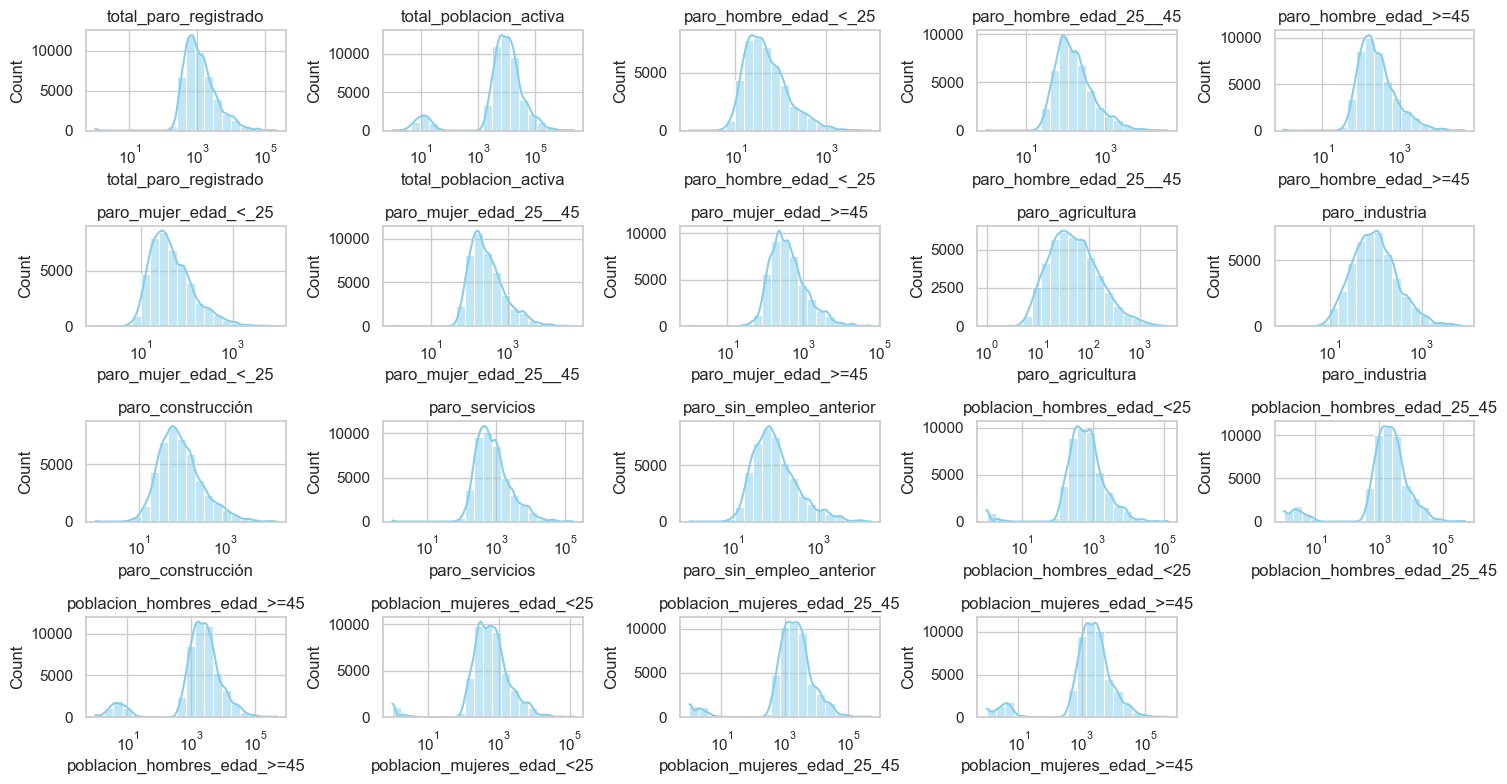

In [48]:
n_cols = 5
n_rows = (len(numericas) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 2*n_rows))
axes = axes.flatten()

for i, col in enumerate(numericas):
    # Filtrar solo valores positivos
    data = df[col][df[col] > 0]
    sns.histplot(data, bins=20, kde=True, ax=axes[i], color='skyblue', log_scale=True)
    axes[i].set_title(col)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


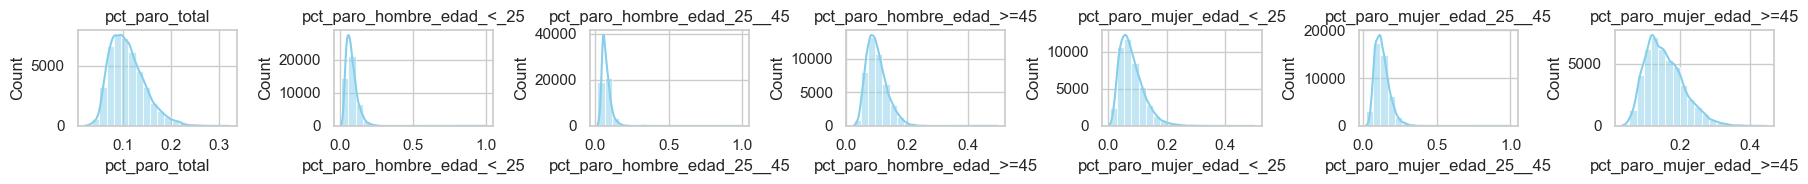

In [49]:
n_cols = 7
n_rows = (len(porcentajes) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 2*n_rows))
axes = axes.flatten()

for i, col in enumerate(porcentajes):
    # Filtrar solo valores positivos
    data = df[col][df[col] > 0]
    sns.histplot(data, bins=20, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(col)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


- Boxplots para detectar outliers

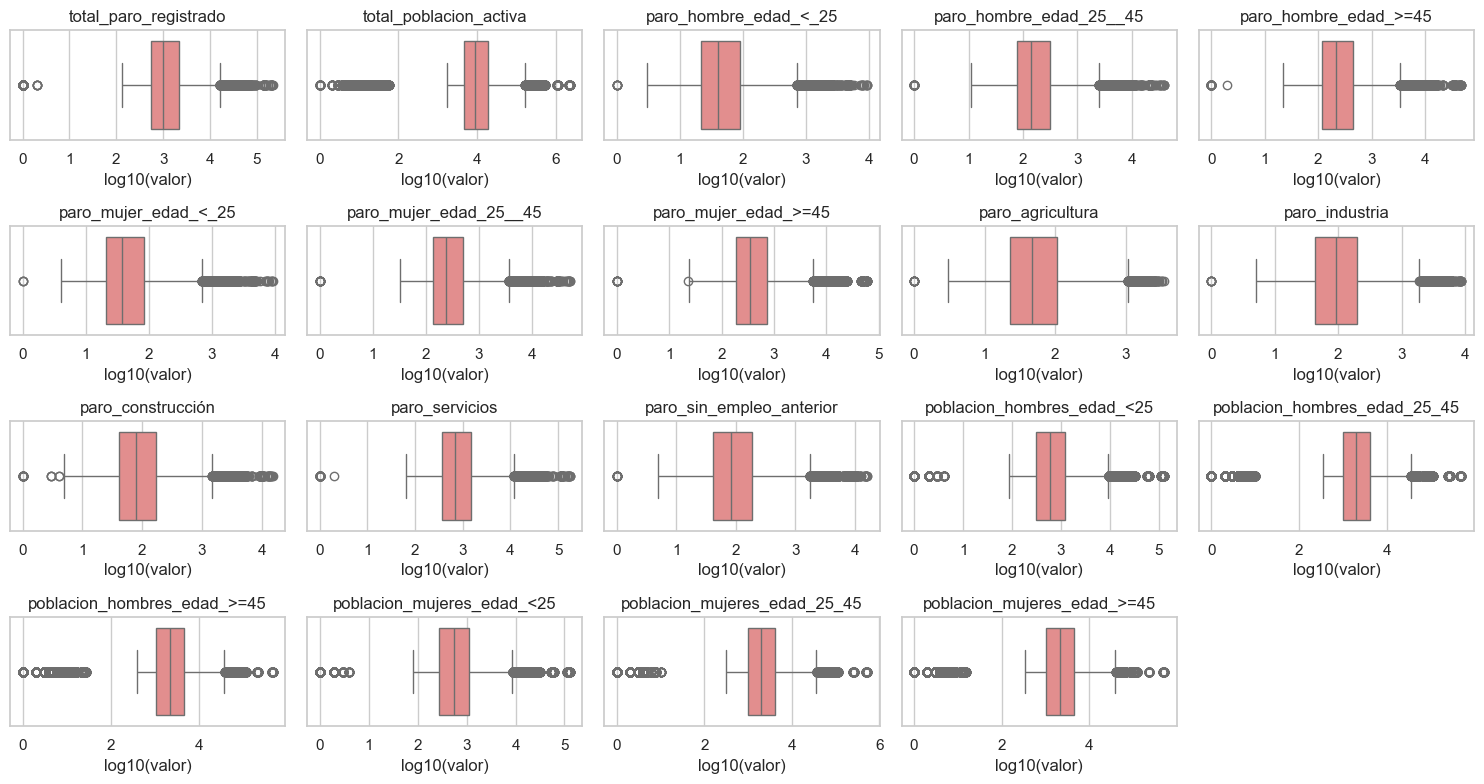

In [50]:
n_cols = 5
n_rows = (len(numericas) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 2*n_rows))
axes = axes.flatten()

for i, col in enumerate(numericas):
    data = df[col][df[col] > 0]
    sns.boxplot(x=np.log10(data), ax=axes[i], color='lightcoral')  # log10 para ver outliers
    axes[i].set_title(col)
    axes[i].set_xlabel('log10(valor)')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- Se observa que los datos tienen mucha desviancion, dejando una cantidad importante de outlainer fuera

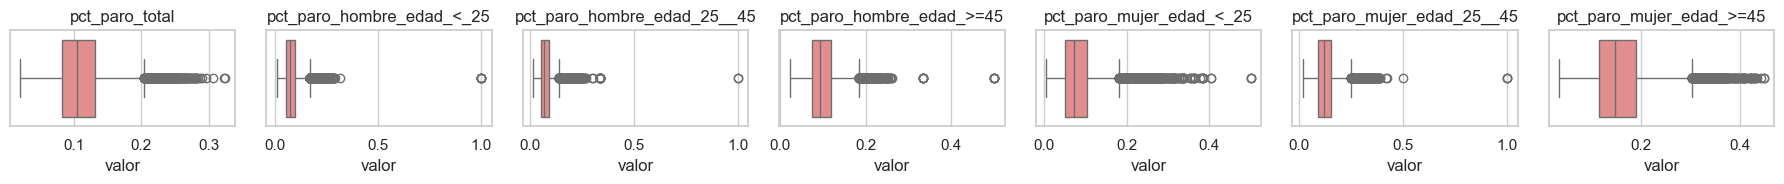

In [51]:
n_cols = 7
n_rows = (len(porcentajes) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 2*n_rows))
axes = axes.flatten()

for i, col in enumerate(porcentajes):
    data = df[col][df[col] > 0]   # si quieres mantener solo valores positivos
    sns.boxplot(x=data, ax=axes[i], color='lightcoral')
    axes[i].set_title(col)
    axes[i].set_xlabel('valor')   # cambiamos etiqueta del eje

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- Correlación entre variables

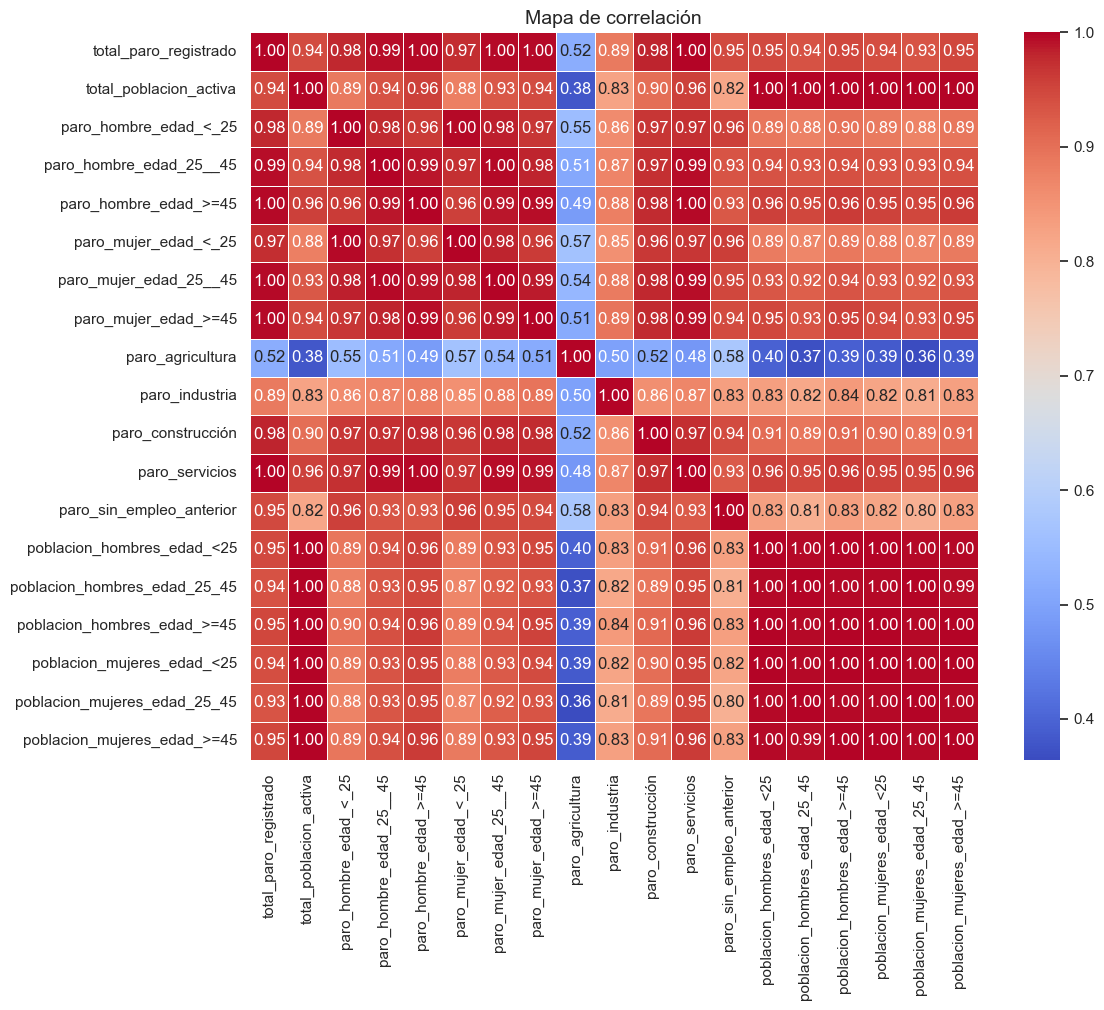

In [52]:
corr = df[numericas].corr()
figsize = (12, 10) 
plt.figure(figsize=figsize)

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=0.5)
plt.title("Mapa de correlación", fontsize=14)
plt.tight_layout()
plt.show()

- Se observa una descorrelacion clara del paro agricola con respecto a los demas grupos de analisis

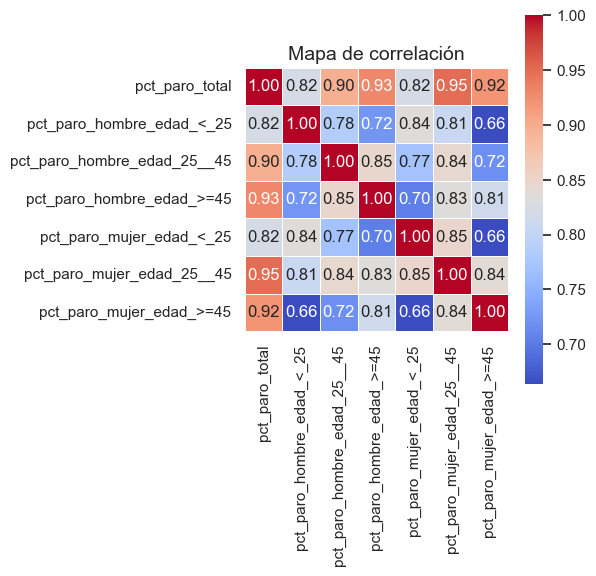

In [53]:
corr = df[porcentajes].corr()
figsize = (6, 6) 
plt.figure(figsize=figsize)

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=0.5)
plt.title("Mapa de correlación", fontsize=14)
plt.tight_layout()
plt.show()

- Se observa mayor correlacion en el paro de mujeres y hombres de mas de 45 años con respecto al paro total

## 2.5 Análisis temporal

- Establecemos fecha como indice

In [54]:
df.set_index('fecha', inplace=True)


-  Graficamos la evolución del paro

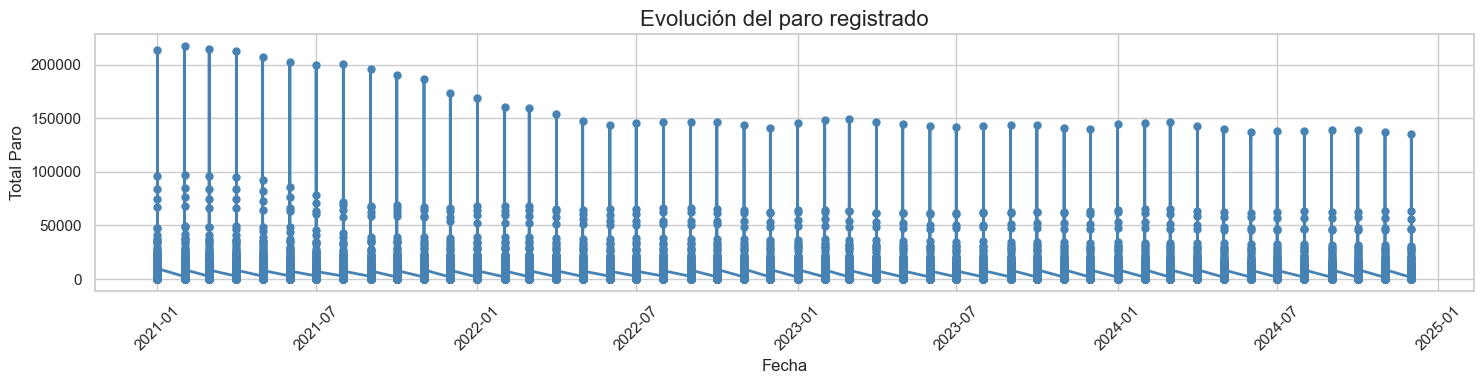

In [55]:
plt.figure(figsize=(15,4))
plt.plot(df.index, df['total_paro_registrado'], marker='o', linestyle='-', color='steelblue', linewidth=2, markersize=5)
plt.title("Evolución del paro registrado", fontsize=16)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Total Paro", fontsize=12)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- El paro absoluto, disminulle significativamente desde 2021 hasta mediados de 2022 donde se observa un estancamiento

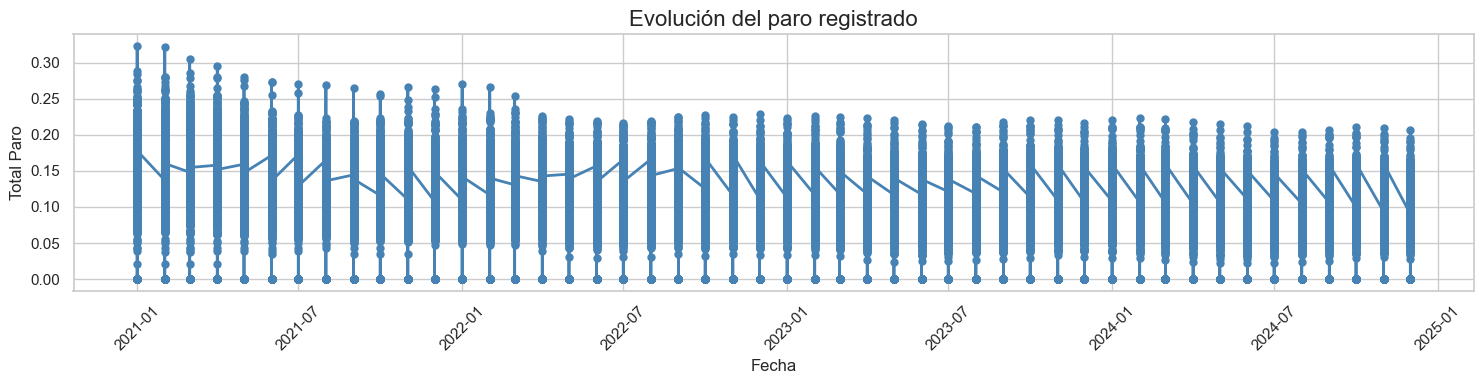

In [56]:
plt.figure(figsize=(15,4))
plt.plot(df.index, df['pct_paro_total'], marker='o', linestyle='-', color='steelblue', linewidth=2, markersize=5)
plt.title("Evolución del paro registrado", fontsize=16)
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Total Paro", fontsize=12)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Se observa evolucion positiva en el paro en el tiempo, se reduce de media del 30% al 20%, con un estancamiento desde 2023

## 2.6 Análisis estadístico simple

- Medidas de tendencia central y dispersión

In [57]:
for col in numericas:
    print(f"\nEstadísticas para {col}:")
    print(f"Media: {df[col].mean()}")
    print(f"Mediana: {df[col].median()}")
    print(f"Desviación estándar: {df[col].std()}")
    print(f"Máximo: {df[col].max()}")
    print(f"Mínimo: {df[col].min()}")


Estadísticas para total_paro_registrado:
Media: 2455.31510930309
Mediana: 886.0
Desviación estándar: 7274.800185251029
Máximo: 217294
Mínimo: 0

Estadísticas para total_poblacion_activa:
Media: 23845.75517751479
Mediana: 8999.5
Desviación estándar: 86177.52119166625
Máximo: 2264298
Mínimo: 1

Estadísticas para paro_hombre_edad_<_25:
Media: 95.27329881656804
Mediana: 35.0
Desviación estándar: 268.4109984847153
Máximo: 9410
Mínimo: 0

Estadísticas para paro_hombre_edad_25__45:
Media: 361.39887409598947
Mediana: 123.0
Desviación estándar: 1152.2520981922235
Máximo: 39292
Mínimo: 0

Estadísticas para paro_hombre_edad_>=45:
Media: 534.9484097633136
Mediana: 187.0
Desviación estándar: 1673.7151007528591
Máximo: 47946
Mínimo: 0

Estadísticas para paro_mujer_edad_<_25:
Media: 90.25827991452991
Mediana: 34.0
Desviación estándar: 254.106067971496
Máximo: 9137
Mínimo: 0

Estadísticas para paro_mujer_edad_25__45:
Media: 569.2940705128206
Mediana: 209.0
Desviación estándar: 1634.6957314473073
Máxi

In [58]:
for col in porcentajes:
    print(f"\nEstadísticas para {col}:")
    print(f"Media: {df[col].mean()}")
    print(f"Mediana: {df[col].median()}")
    print(f"Desviación estándar: {df[col].std()}")
    print(f"Máximo: {df[col].max()}")
    print(f"Mínimo: {df[col].min()}")


Estadísticas para pct_paro_total:
Media: 0.09962440463123103
Mediana: 0.10006331874971974
Desviación estándar: 0.047052826498506624
Máximo: 0.3230697920805191
Mínimo: 0.0

Estadísticas para pct_paro_hombre_edad_<_25:
Media: 0.07015969019672506
Mediana: 0.06570498895560745
Desviación estándar: 0.043725784647807034
Máximo: 1.0
Mínimo: 0.0

Estadísticas para pct_paro_hombre_edad_25__45:
Media: 0.06570633832996368
Mediana: 0.0632194594409749
Desviación estándar: 0.0355665209933227
Máximo: 1.0
Mínimo: 0.0

Estadísticas para pct_paro_hombre_edad_>=45:
Media: 0.09028678589709378
Mediana: 0.0905352676453515
Desviación estándar: 0.04348565737226074
Máximo: 0.5
Mínimo: 0.0

Estadísticas para pct_paro_mujer_edad_<_25:
Media: 0.07308715554278813
Mediana: 0.0677966101694915
Desviación estándar: 0.046549355738761594
Máximo: 0.5
Mínimo: 0.0

Estadísticas para pct_paro_mujer_edad_25__45:
Media: 0.11604477680945592
Mediana: 0.11467447537492155
Desviación estándar: 0.06046477415785772
Máximo: 1.0
Mínim

- La media del paro sobre la poblacion examina, es de un 10%
- Se observa una media de desempleo mayor en mujeres que en hombres
- Se observa mayor paro cuanto mas edad tiene el grupo de analisis

# 3 Finalizacion

- El dataset a sido procesado, limpiado, se realizo las agregaciones oportunas y de agrego dados complementarios, con este dataset, tenemos una buena base para continuar el analisis y el dashboard en excel o powerbi.